In [1]:
import os
import sys 
import glob
import time
import re
import random
from pathlib import Path

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from efficientnet_pytorch_3d import EfficientNet3D

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')


In [9]:
data_root = Path('../preprocessed_array/')

mri_types = ['FLAIR','T1w','T1wCE','T2w']
SIZE = 256
NUM_IMAGES = 64

## Check GPU 

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
GeForce GTX 1660 Ti with Max-Q Design


## Data Loading & Preprocessing

In [4]:
#get image plane
def get_image_plane(data):
    x1, y1, _, x2, y2, _ = [round(j) for j in data.ImageOrientationPatient]
    cords = [x1, y1, x2, y2]

    if cords == [1, 0, 0, 0]:
        return 'Coronal'
    elif cords == [1, 0, 0, 1]:
        return 'Axial'
    elif cords == [0, 1, 0, 0]:
        return 'Sagittal'
    else:
        return 'Unknown'
    
    
#get voxel data & orient voxel    
def get_voxel(study_id, scan_type, train = True):
    imgs = []
    if train :
        DATASET = 'train'
    else :
        DATASET = 'test'
    dcm_dir = data_root.joinpath(DATASET, study_id, scan_type)
    dcm_paths = sorted(dcm_dir.glob("*.dcm"), key=lambda x: int(x.stem.split("-")[-1]))
    positions = []
    
    for dcm_path in dcm_paths:
        img = pydicom.dcmread(str(dcm_path))
        imgs.append(img.pixel_array)
        positions.append(img.ImagePositionPatient)
        
    plane = get_image_plane(img)
    voxel = np.stack(imgs)
    
    # reorder planes if needed and rotate voxel
    if plane == "Coronal":
        if positions[0][1] < positions[-1][1]:
            voxel = voxel[::-1]
#             print(f"{study_id} {scan_type} {plane} reordered")
        voxel = voxel.transpose((1, 0, 2))
    elif plane == "Sagittal":
        if positions[0][0] < positions[-1][0]:
            voxel = voxel[::-1]
#             print(f"{study_id} {scan_type} {plane} reordered")
        voxel = voxel.transpose((1, 2, 0))
        voxel = np.rot90(voxel, 2, axes=(1, 2))
    elif plane == "Axial":
        if positions[0][2] > positions[-1][2]:
            voxel = voxel[::-1]
#             print(f"{study_id} {scan_type} {plane} reordered")
        voxel = np.rot90(voxel, 2)
    else:
        raise ValueError(f"Unknown plane {plane}")
    return voxel, plane

#normalize
def normalize_contrast(voxel):
    if voxel.sum() == 0:
        return voxel
    voxel = voxel - np.min(voxel)
    voxel = voxel / np.max(voxel)
    voxel = (voxel * 255).astype(np.uint8)
    return voxel

#crop voxel based on non zero values
def crop_voxel(voxel):
    if voxel.sum() == 0:
        return voxel
    keep = (voxel.mean(axis=(0, 1)) > 0)
    voxel = voxel[:, :, keep]
    keep = (voxel.mean(axis=(0, 2)) > 0)
    voxel = voxel[:, keep]
    keep = (voxel.mean(axis=(1, 2)) > 0)
    voxel = voxel[keep]
    return voxel

#resize the voxel across all the axes
def resize_voxel(voxel, sz=64):
    output = np.zeros((sz, sz, sz), dtype=np.uint8)

    if np.argmax(voxel.shape) == 0:
        for i, s in enumerate(np.linspace(0, voxel.shape[0] - 1, sz)):
            output[i] = cv2.resize(voxel[int(s)], (sz, sz))
    elif np.argmax(voxel.shape) == 1:
        for i, s in enumerate(np.linspace(0, voxel.shape[1] - 1, sz)):
            output[:, i] = cv2.resize(voxel[:, int(s)], (sz, sz))
    elif np.argmax(voxel.shape) == 2:
        for i, s in enumerate(np.linspace(0, voxel.shape[2] - 1, sz)):
            output[:, :, i] = cv2.resize(voxel[:, :, int(s)], (sz, sz))

    return output
    

In [5]:
#set seeed
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(12)

In [6]:
#train & val split
train_labels = pd.read_csv(data_root.joinpath('train_labels.csv'))
display(train_labels.head())

df_train, df_valid = train_test_split(
    train_labels, 
    test_size=0.2, 
    random_state=12, 
    stratify=train_labels["MGMT_value"],
)

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [7]:
train_labels['MGMT_value'].unique()

array([1, 0], dtype=int64)

## Save created Tensors

In [8]:
mri_types

['FLAIR', 'T1w', 'T1wCE', 'T2w']

In [28]:
save_path = Path('../preprocessed_array/')

In [31]:
# scan_id_list = os.listdir(data_root.joinpath('train'))

# for scan_id in scan_id_list :
    
#     for scan_type in mri_types :
        
#         voxel, plane = get_voxel(scan_id, scan_type) 
#         voxel = normalize_contrast(voxel)
#         voxel = crop_voxel(voxel)
#         voxel = resize_voxel(voxel)
        
#         os.makedirs(save_path.joinpath('train').joinpath(scan_id).joinpath(scan_type))
        
#         np.save(file= f'{save_path}/train/{scan_id}/{scan_type}/voxel', arr= voxel)
        

In [14]:
array = np.load('../preprocessed_array/train/00000/FLAIR/voxel.npy')

## Datasets 

In [15]:
class MRIScanDataset(Dataset) :
    
    def __init__(self, paths, targets=None, mri_type=None, 
                 label_smoothing=0.01, split="train", 
                 augment=False) :
        
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.label_smoothing = label_smoothing
        self.split = split
        self.augment = augment
        
        
    def __len__(self) :
        return len(self.paths)
    
    def __getitem__(self, index) :
        
        scan_id = str(self.paths[index]).zfill(5)
        mri_type = self.mri_type[index]
        
        #for prediction data
        if self.targets is None: 
            voxel = np.load(data_root.joinpath('train').joinpath(scan_id).joinpath(mri_type).joinpath('voxel.npy'))
            
        #for training data when label is present
        else:
            if self.augment:
                rotation = np.random.randint(0,4)
            else:
                rotation = 0
             
            voxel = np.load(data_root.joinpath('train').joinpath(scan_id).joinpath(mri_type).joinpath('voxel.npy'))
            voxel = np.expand_dims(voxel,0)
            
            
        if self.targets is None:
            return {"X": torch.tensor(voxel).float(), "id": scan_id}
        else:
            y = torch.tensor(abs(self.targets[index]-self.label_smoothing), dtype=torch.float)
            return {"X": torch.tensor(voxel).float(), "y": y}
               

In [16]:
df_train.loc[:,"MRI_Type"] = 'FLAIR'
train_dataset = MRIScanDataset(
        df_train["BraTS21ID"].values, 
        df_train["MGMT_value"].values, 
        df_train["MRI_Type"].values,
        augment=False)

train_loader = DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=True )


for data in train_loader :
    X1 = data['X']
    y1 = data['y']
    print(X1.shape)
    print(y1.shape)
    break

torch.Size([16, 1, 64, 64, 64])
torch.Size([16])


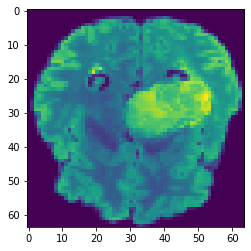

In [17]:
example = X1[0][0]
plt.imshow(np.array(example)[32])

## Model 

In [24]:
# class EfficientNetb1(nn.Module):
    
#     def __init__(self):
        
#         super().__init__()
#         self.net = EfficientNet3D.("efficientnet-b1", override_params={'num_classes': 2}, in_channels=1)
#         n_features = self.net._fc.in_features
#         self.net._fc = nn.Linear(in_features=n_features, out_features=1, bias=True)
    
#     def forward(self, x):
#         out = self.net(x)
#         return out

In [80]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv_layer1 = self._conv_layer_set(1, 16)
        self.conv_layer2 = self._conv_layer_set(16, 32)
        self.fc1 = nn.Linear(14*30*30*32, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.LeakyReLU()
        self.batch=nn.BatchNorm1d(64)
        self.drop=nn.Dropout(p=0.15)        
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=(3, 3, 3), padding=0),
        nn.LeakyReLU(),
        nn.MaxPool3d((2, 2, 2)),
        )
        return conv_layer
    

    def forward(self, x):
        # Set 1
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.batch(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out

In [81]:
model = CNNModel()
print(model)

CNNModel(
  (conv_layer1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=403200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (batch): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.15, inplace=False)
)


## Train Model 

In [83]:
class TrainModel:
    
    def __init__(self, model, device, 
                optimizer, criterion ):
        
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        
        self.best_valid_score = np.inf
        self.n_patience = 0
        self.lastmodel = None
        
    def fit(self, epochs, train_dataloader, valid_dataloader, save_path, patience):
        
        start_time = time.time()
        
        for epoch in range(1, epochs + 1):
            
            print(f'Running Epoch {epoch}...................')
            
            train_loss, train_auc = self.train(train_dataloader)
            val_loss, val_auc = self.validation(valid_dataloader)
            
            print(f'For Epoch {epoch :>7d} Train Loss {train_loss : >5f} Train AUC {train_auc} Val Loss {val_loss} Val AUC {val_auc} ')
            print(f'Time Taken till Epoch {epoch :>7d} Time Taken {(time.time() - start_time)/60}')
            
            
            if self.best_valid_score > val_loss: 
                
                self.save_model(epoch, save_path, val_loss, val_auc)
                print(f'AUC Improved from {self.best_valid_score :4f} to {val_loss}. Saved model to {self.lastmodel}')
                
                #updating the lossed
                self.best_valid_score = val_loss
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                print(f"\nValid auc didn't improve last {patience} epochs.")
                break
            
            
            
    def train(self, train_dataloader) :
        '''
        For Training the model.
        We will be calculating batch wise loss and 
        finally calcualting auc on the overall y
        '''
    
        self.model.train()
        sum_loss = 0
        y_all = []
        output_all = []
        start_time = time.time()

        for batch, data in enumerate(train_dataloader) :

            X = data['X'].to(self.device)
            y = data['y'].to(self.device)

            self.optimizer.zero_grad()     #clearning the accumulated gradients
            pred = self.model(X).squeeze(1)           #make the prediction
            loss = self.criterion(pred, y) #calcualte the loss
            loss.backward()           #backpropagation
            self.optimizer.step()          #update weights

            sum_loss += loss.detach().item()
            y_all.extend(data['y'].tolist()) #save all y values to y_val
            output_all.extend(torch.sigmoid(pred).tolist())  #save all pred to output all

            #print peformance
            if batch % 20 == 0 :
                time_taken = (time.time() - start_time)
                start_time = time.time()
                print(f'Train Batch {batch + 1 :>7d} Loss : {sum_loss/(batch +1)} Time Taken : {time_taken/60} ')

        y_all = [1 if x > 0.5 else 0 for x in y_all]
        train_auc = roc_auc_score(y_all, output_all)

        return sum_loss/len(train_dataloader) , train_auc
    
    
    
    def validation(self, val_dataloader) :
    
        self.model.eval()
        sum_loss = 0
        y_all = []
        output_all = []

        for batch, data in enumerate(val_dataloader) :

            with torch.no_grad() :

                X_val = data['X'].to(self.device)
                y_val = data['y'].to(self.device)

                pred = self.model(X_val).squeeze(1)   #make the prediction
                loss = self.criterion(pred, y_val) #calcualte the loss

                sum_loss += loss.detach().item()
                y_all.extend(data['y'].tolist()) #save all y values to y_val
                output_all.extend(torch.sigmoid(pred).tolist())  #save all pred to output all

                #print peformance
                if batch % 20 == 0 :
                    print(f'Test Batch {batch + 1 :>7d} Loss : {sum_loss/(batch +1)}')

        y_all = [1 if x > 0.5 else 0 for x in y_all]
        val_auc = roc_auc_score(y_all, output_all)

        return sum_loss/len(val_dataloader) , val_auc

            
    def save_model(self, n_epoch, save_path, loss, auc):
        
        self.lastmodel = f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth"
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )

In [84]:
#train the model
def train_mri_type(df_train, df_valid, mri_type):
    
    #creating data based on selected mri_type
    if mri_type=="all":
        train_list = []
        valid_list = []
        for mri_type in mri_types:
            df_train.loc[:,"MRI_Type"] = mri_type
            train_list.append(df_train.copy())
            df_valid.loc[:,"MRI_Type"] = mri_type
            valid_list.append(df_valid.copy())

        df_train = pd.concat(train_list)
        df_valid = pd.concat(valid_list)
        
    else:
        df_train.loc[:,"MRI_Type"] = mri_type
        df_valid.loc[:,"MRI_Type"] = mri_type

    print(df_train.shape, df_valid.shape)
    display(df_train.head())
    
    #train dataset
    train_dataset = MRIScanDataset(
        df_train["BraTS21ID"].values, 
        df_train["MGMT_value"].values, 
        df_train["MRI_Type"].values,
        augment=False)
    
    #valid dataset
    valid_dataset = MRIScanDataset(
        df_valid["BraTS21ID"].values, 
        df_valid["MGMT_value"].values,
        df_valid["MRI_Type"].values)
    
    #train dataloader
    train_loader = DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=True)

    valid_loader = DataLoader(
        valid_dataset, 
        batch_size=8,
        shuffle=False
    )
    
    #load model
    model = CNNModel()
    model.to(device)
    
    #define optimizer & criterion
    criterion = F.binary_cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    

    trainer = TrainModel(model, device, 
                    optimizer,criterion)

    history = trainer.fit(epochs= 10, train_dataloader= train_loader, valid_dataloader= valid_loader, save_path= f"09_10_efficient_net_model/{mri_type}", patience= 10)
    
    return trainer.lastmodel

In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [86]:
%%time
modelfiles = None

if not modelfiles:
    modelfiles = [train_mri_type(df_train, df_valid, m) for m in mri_types]
    print(modelfiles)

(468, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
446,645,0,FLAIR
529,777,1,FLAIR
420,607,1,FLAIR
406,589,0,FLAIR
475,690,1,FLAIR


RuntimeError: CUDA error: device-side assert triggered